In [8]:
import xarray as xr
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
# %matplotlib inline
import os

### Read in NDVI data

In [9]:
ds=xr.open_mfdataset(
    '/g/data/oe9/user/rg6346/VI_mask_nc/NDVI/NDVI_????.nc',
    chunks=dict(long=176)) 
ds=ds.rename({'ndvi_evi':'ndvi'})
ds=ds.drop('band')
ds['ndvi']=ds.ndvi/10000;
ds

<xarray.Dataset>
Dimensions:  (lat: 3147, long: 3344, time: 388)
Coordinates:
  * lat      (lat) float64 -24.59 -24.59 -24.6 -24.6 -24.6 -24.61 -24.61 ...
  * long     (long) float64 138.6 138.6 138.6 138.6 138.6 138.6 138.6 138.6 ...
  * time     (time) datetime64[ns] 2000-02-18 2000-03-05 2000-03-21 ...
Data variables:
    ndvi     (time, lat, long) float64 dask.array<shape=(388, 3147, 3344), chunksize=(20, 3147, 176)>

## Subset data for testing

In [10]:
%%time
sub=ds.sel(lat=slice(-30.1, -31),long=slice(148.9,150.6)) ##yarrie
sub.load()

CPU times: user 5.96 s, sys: 57.1 s, total: 1min 3s
Wall time: 4min 6s


### Resample to quarterly, extract seasons

In [1]:
ndvi_q=sub.ndvi.resample(time='Q-FEB').mean(dim='time')
ndvi_jja=ndvi_q.where(ndvi_q['time.season']=='JJA',drop=True)
ndvi_djf=ndvi_q.where(ndvi_q['time.season']=='DJF',drop=True)
ndvi_jja.time

NameError: name 'sub' is not defined

## Resample

In [18]:
ndvi_q=sub.ndvi.resample(time='1A').std(dim='time')
ndvi_q

/g/data/oe9/software/anaconda/envs/geo/lib/python3.6/site-packages/xarray/core/common.py:594: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)


<xarray.DataArray 'ndvi' (time: 17, lat: 216, long: 408)>
array([[[0.120004, 0.100412, ..., 0.100171, 0.096773],
        [0.085825, 0.116587, ..., 0.094929, 0.09729 ],
        ...,
        [0.123655, 0.130823, ..., 0.073476, 0.056114],
        [0.159533, 0.184309, ..., 0.068281, 0.062664]],

       [[0.101686, 0.098697, ..., 0.067283, 0.06365 ],
        [0.123417, 0.102494, ..., 0.058442, 0.062369],
        ...,
        [0.189919, 0.193828, ..., 0.074417, 0.064306],
        [0.215948, 0.208236, ..., 0.079866, 0.05504 ]],

       ...,

       [[0.171899, 0.162242, ..., 0.097739, 0.084923],
        [0.201605, 0.187649, ..., 0.075093, 0.065582],
        ...,
        [0.283386, 0.274051, ..., 0.088863, 0.079042],
        [0.279137, 0.276184, ..., 0.11735 , 0.077811]],

       [[0.216955, 0.228899, ..., 0.184244, 0.177857],
        [0.106181, 0.182799, ..., 0.167656, 0.148997],
        ...,
        [0.129439, 0.153883, ..., 0.105441, 0.085169],
        [0.106631, 0.177132, ..., 0.139343, 0.

## Calculate and plot seasonal variance

In [7]:
#calculate stdev
ndvi_jja_std=ndvi_jja.std(dim='time')
ndvi_djf_std=ndvi_djf.std(dim='time')


NameError: name 'ndvi_jja' is not defined

In [36]:
both = xr.concat([ndvi_djf_std, ndvi_jja_std],dim=pd.Series(['DJF', 'JJA'], name='season', dtype='U'))
both

<xarray.DataArray (season: 2, lat: 216, long: 408)>
array([[[0.108663, 0.12152 , ..., 0.107392, 0.108449],
        [0.068411, 0.088082, ..., 0.099538, 0.096944],
        ...,
        [0.092365, 0.096102, ..., 0.065473, 0.067461],
        [0.103703, 0.094605, ..., 0.068367, 0.054098]],

       [[0.113357, 0.099587, ..., 0.093185, 0.085474],
        [0.129797, 0.101819, ..., 0.072853, 0.06771 ],
        ...,
        [0.161801, 0.154272, ..., 0.059472, 0.047602],
        [0.170902, 0.165734, ..., 0.063314, 0.044474]]])
Coordinates:
  * lat      (lat) float64 -30.1 -30.11 -30.11 -30.11 -30.12 -30.12 -30.13 ...
  * long     (long) float64 148.9 148.9 148.9 148.9 148.9 148.9 148.9 148.9 ...
  * season   (season) object 'DJF' 'JJA'

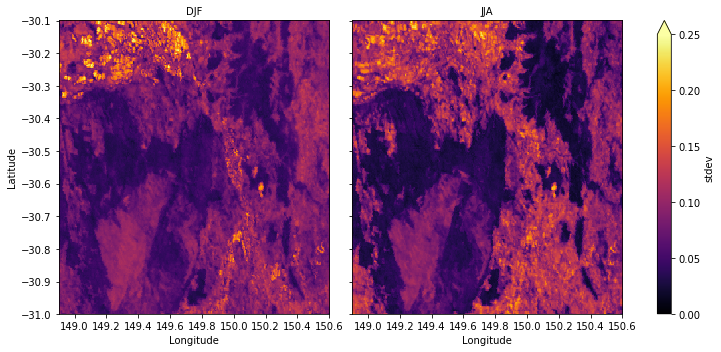

In [38]:
cmap='inferno'
vmin=0
vmax=.25
    
fig=plt.figure()
j = both.plot.imshow(col='season', robust=True,cmap=cmap,vmin=vmin, vmax=vmax,size=5)
j.cbar.set_label('stdev')
j.set_xlabels('Longitude')
j.set_ylabels('Latitude')
j.set_titles(template='{value}')
plt.ioff()

# # fig.suptitle('Variance 2001-2016')

# path='/home/156/jbw156/team-drip/figures/seasonalvariance_Yarrie.png'
# plt.savefig(path,dpi=300,bbox_inches='tight')

## Seasonality

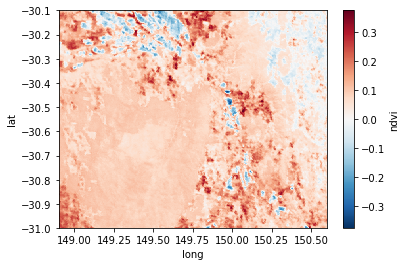

In [116]:
season = sub.groupby('time.season').mean('time')
seasonality=season.sel(season='JJA')-season.sel(season='DJF')
seasonality.ndvi.plot.imshow()


## Winter vs. Summer area averaged

In [6]:
ndvi_jja_avg=ndvi_jja.mean(dim=('lat','long'))
ndvi_djf_avg=ndvi_djf.mean(dim=('lat','long'))


NameError: name 'ndvi_jja' is not defined

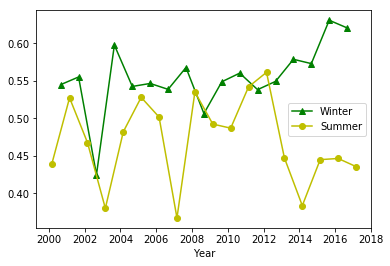

In [64]:
import matplotlib.pyplot as plt
# fname = '/home/599/rg6346/EVI_test.png'
fig = plt.figure()
plt.plot(ndvi_jja_avg.time,ndvi_jja_avg,'g^-',label='Winter')
plt.plot(ndvi_djf_avg.time,ndvi_djf_avg,'yo-',label='Summer')
# fig.savefig(fname, dpi=300)
plt.xlabel('Year')
leg = plt.legend()

## Plot time series anomaly


In [15]:
seas=ndvi_q['time.season']
ndvi_mean=ndvi_q.mean(dim=('time'))

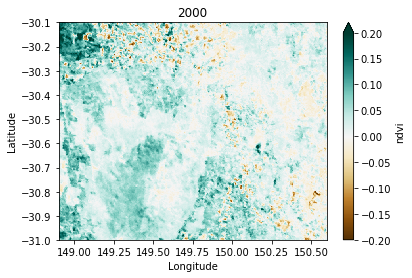

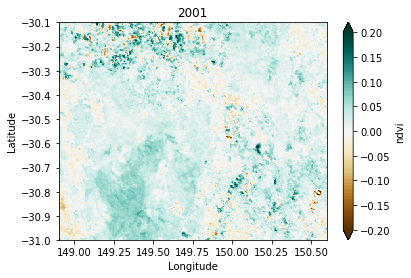

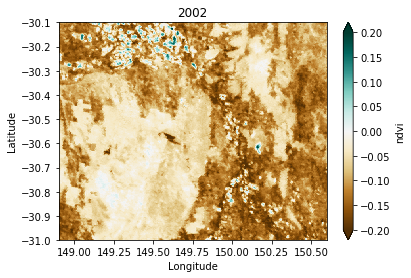

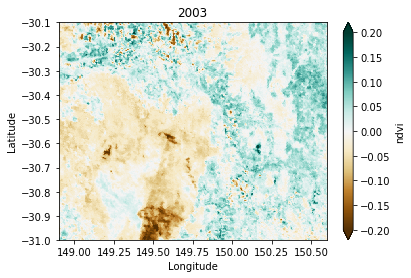

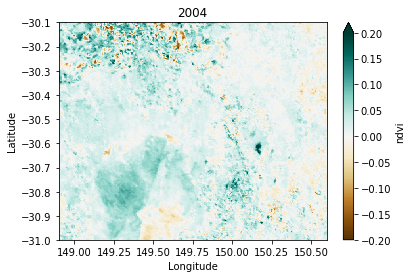

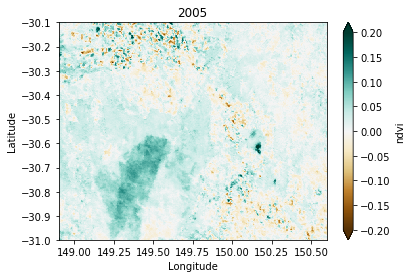

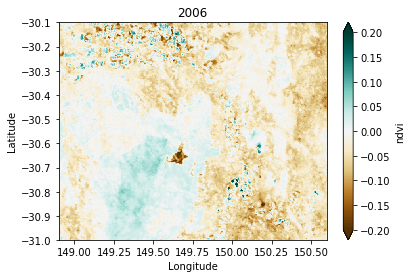

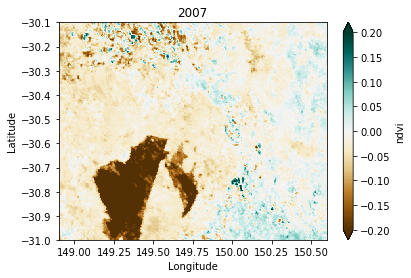

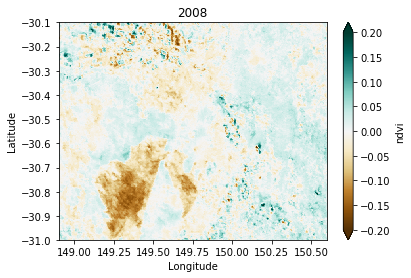

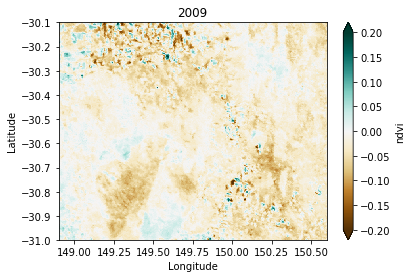

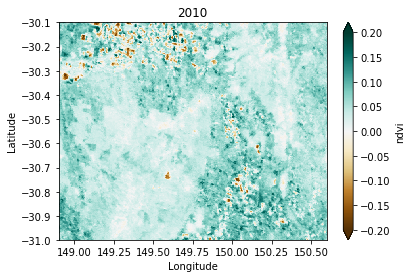

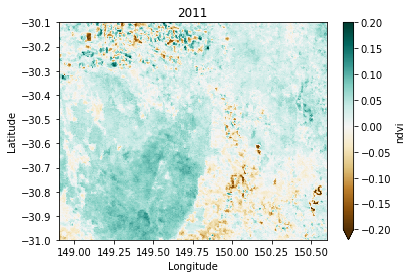

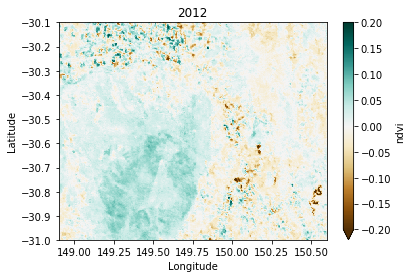

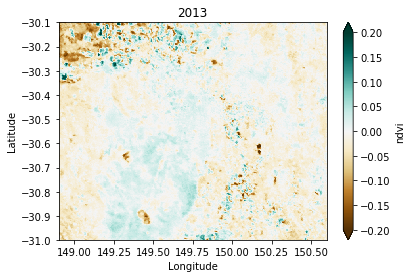

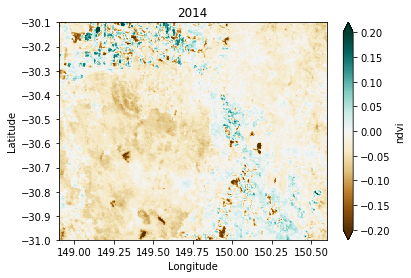

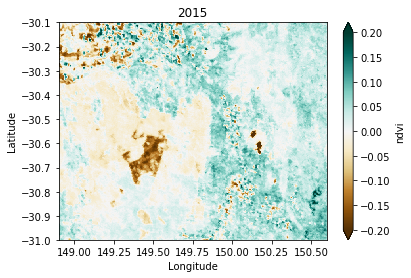

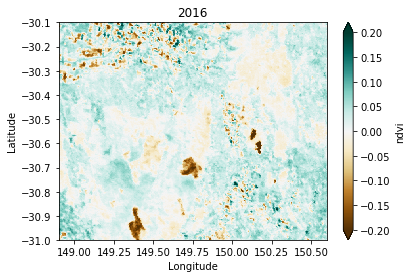

In [17]:
## Yatrie anomaly loop
save_path = '/home/156/jbw156/team-drip/figures/yarrie_annual/'
for i,step in enumerate(ndvi_q.time):
    
    fig=plt.figure()
    anomaly=ndvi_q.sel(time=step)-ndvi_mean
    anomaly.plot.imshow(robust=True,cmap='BrBG',vmin=-.2,vmax=.2)
#     plt.axes().set_aspect('equal', 'datalim')    
    
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    t=pd.to_datetime(step.values) 
    timestring = t.strftime('%Y')
#     season=seas.data[i]
#     plt.title(season+' ' +timestring)
    plt.title(timestring)
    #   timestring2 = t.strftime('%Y%m')


    completeName = os.path.join(save_path,"{y}yarrie_ndvi_anom.png".format(y=timestring))  
    plt.savefig(completeName)
    plt.close
#     print(timestring)


Text(0.5,1,'DJF 2005')

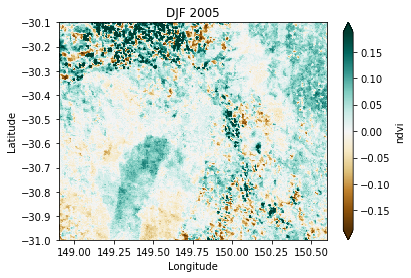

In [191]:
step=20
fig=plt.figure()
anomaly=ndvi_q.isel(time=step)-ndvi_mean
anomaly.plot.imshow(robust=True,cmap='BrBG')
#     plt.axes().set_aspect('equal', 'datalim')    

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.ioff()

t=pd.to_datetime(ndvi_q.time.values) 
timestring = t.strftime('%Y')

season=seas.data[step]
plt.title(season+' ' +timestring[step])

##  Variance in time

In [32]:
baseline=ndvi_q.mean(dim='time')
baseline

<xarray.DataArray 'ndvi' (lat: 216, long: 408)>
array([[0.119456, 0.119392, 0.120361, ..., 0.116049, 0.115853, 0.111439],
       [0.120553, 0.126575, 0.12218 , ..., 0.107653, 0.104183, 0.09873 ],
       [0.127143, 0.132225, 0.124475, ..., 0.101927, 0.091679, 0.094868],
       ...,
       [0.162458, 0.167686, 0.171759, ..., 0.09223 , 0.081443, 0.087192],
       [0.161301, 0.165249, 0.16754 , ..., 0.105275, 0.079419, 0.075776],
       [0.166624, 0.172058, 0.172058, ..., 0.091734, 0.091734, 0.068913]])
Coordinates:
  * lat      (lat) float64 -30.1 -30.11 -30.11 -30.11 -30.12 -30.12 -30.13 ...
  * long     (long) float64 148.9 148.9 148.9 148.9 148.9 148.9 148.9 148.9 ...

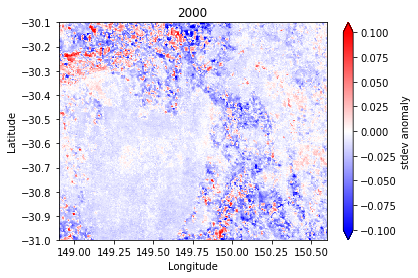

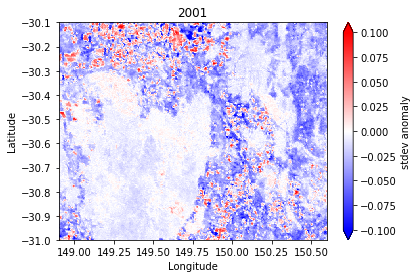

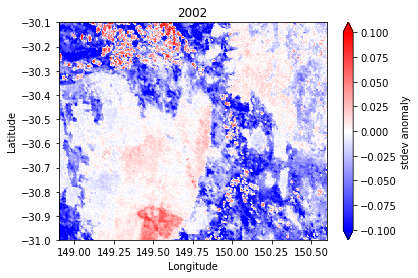

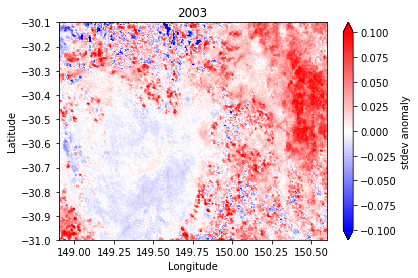

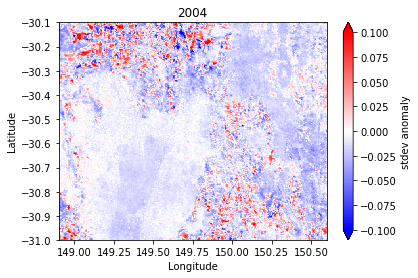

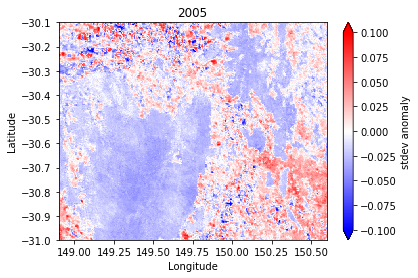

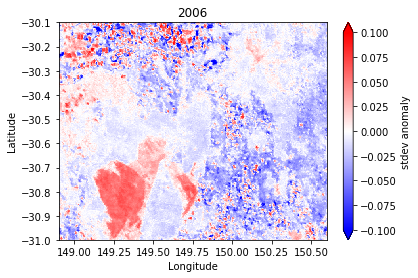

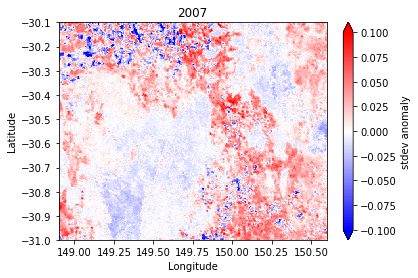

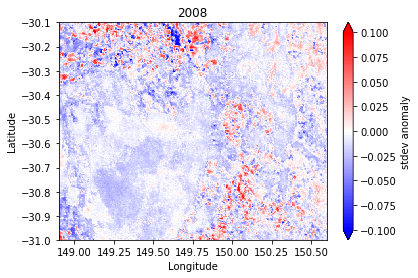

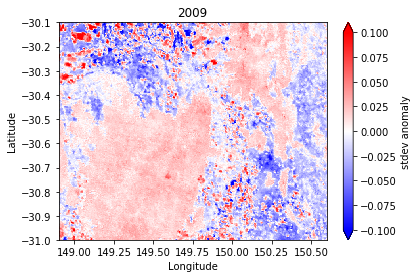

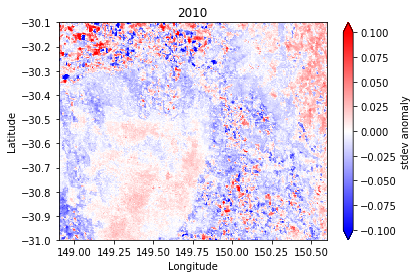

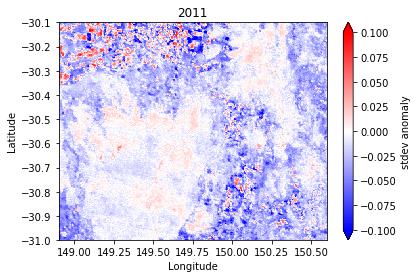

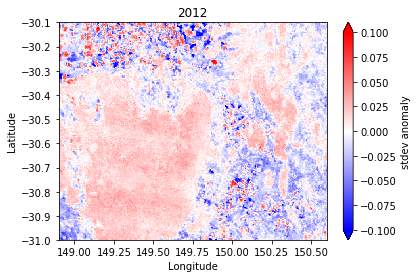

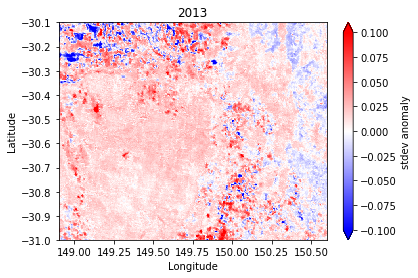

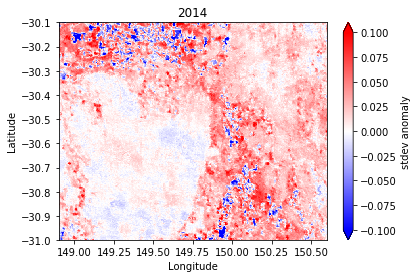

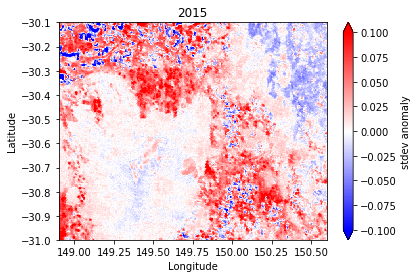

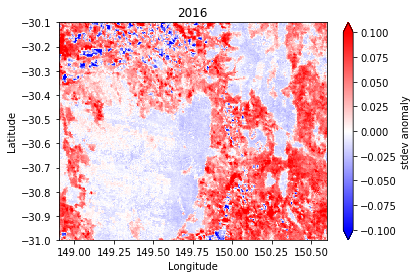

In [33]:
## Yatrie anomaly loop
save_path = '/home/156/jbw156/team-drip/figures/yarrie_d_var/'
for i,step in enumerate(ndvi_q.time):
    
    fig=plt.figure()
    anomaly=ndvi_q.sel(time=step)-baseline
    j = anomaly.plot.imshow(robust=True,cmap='bwr',vmin=-.1,vmax=.1)
#     plt.axes().set_aspect('equal', 'datalim')    
    j.colorbar.set_label('stdev anomaly')
    
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    t=pd.to_datetime(step.values) 
    timestring = t.strftime('%Y')
#     season=seas.data[i]
#     plt.title(season+' ' +timestring)
    plt.title(timestring)
    #   timestring2 = t.strftime('%Y%m')
 

    completeName = os.path.join(save_path,"{y}yarrie_ndvi_annvar.png".format(y=timestring))  
    plt.savefig(completeName)
    plt.close
#     print(timestring)

In [ ]:
## animate?

In [12]:
%matplotlib tk
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

rg = np.arange(-5, 5, 0.1)
x, y = np.meshgrid(rg, rg)
r2 = x**2 + y**2
z = np.sin(r2)/r2

fig = plt.figure()
im = plt.imshow(z)

def make_frame(t):
    z = np.sin(r2 + 0.5*t) / r2
    im.set_array(z)
    return im

animation.FuncAnimation(fig, make_frame, blit=False)

In [ ]:
import numpy as np
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import matplotlib.animation as animation


def update_line(num, data, line):
    line.set_data(data[..., :num])
    return line,

# Fixing random state for reproducibility
np.random.seed(19680801)


# Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)


fig1 = plt.figure()

data = np.random.rand(2, 25)
l, = plt.plot([], [], 'r-')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('x')
plt.title('test')
line_ani = animation.FuncAnimation(fig1, update_line, 25, fargs=(data, l),
                                   interval=50, blit=True)
line_ani.save('lines.mp4', writer=writer)

fig2 = plt.figure()

x = np.arange(-9, 10)
y = np.arange(-9, 10).reshape(-1, 1)
base = np.hypot(x, y)
ims = []
for add in np.arange(15):
    ims.append((plt.pcolor(x, y, base + add, norm=plt.Normalize(0, 30)),))

im_ani = animation.ArtistAnimation(fig2, ims, interval=50, repeat_delay=3000,
                                   blit=True)
im_ani.save('im.mp4', writer=writer)